# Setting up

In [2]:
# activiate inline plotting
%matplotlib inline
from setup import *

In [3]:
#import data
#the data used in this study have been pre-converted into an hdf5 file. 
#to preprocess your own data, please use limix command line brinary
file_name = tutorial_data.get_file('arab107')
geno_reader  = gr.genotype_reader_tables(file_name)
pheno_reader = phr.pheno_reader_tables(file_name)

#the data object allows to query specific genotype or phenotype data
dataset = data.QTLData(geno_reader=geno_reader,pheno_reader=pheno_reader)

In [4]:
#flowering phenotypes
phenotype_names = ['5_FT10','6_FT16','7_FT22']
phenotype_ID =  phenotype_names[1]

In [5]:
#load first flowering phenotype
#phenotype_query = "(phenotype_ID=='%s')" %  phenotype_ID
phenotype_query = "(phenotype_ID in %s)" %  str(phenotype_names)

data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                           intersection=True)

sample_relatedness_unnormalized = data_subsample.getCovariance(normalize=True,center=True)

sample_relatedness  = sample_relatedness_unnormalized/ \
    sample_relatedness_unnormalized.diagonal().mean()

if 1:
    #subsample for speed?
    Is = sp.arange(dataset.geno_pos.shape[0])
    #take every 10th SNP
    Is = Is[::10]
    data_subsample = data_subsample.subsample(cols_geno = Is)

    
#get variables we need from data
snps = data_subsample.getGenotypes(center=False,unit=False)
position = data_subsample.getPos()
position,chromBounds = data_util.estCumPos(position=position,offset=100000)

phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                     intersection=True) 
phenotype_std = preprocess.rankStandardizeNormal(phenotypes.values)

N = snps.shape[0]
S = snps.shape[1]
P = phenotypes.shape[1]
print "loaded %d samples, %d phenotypes, %s snps" % (N,P,S)

loaded 192 samples, 3 phenotypes, 21456 snps


# Standard linear regression

In [6]:
#run linear regression
covs = None                 #covariates
searchDelta = False         #specify if delta should be optimized for each SNP
test="lrt"                  #specify type of statistical test

# Running the analysis
# when cov are not set (None), LIMIX considers an intercept (covs=SP.ones((N,1)))

lm = qtl.test_lm(snps=snps,pheno=phenotype_std,
                   covs=covs, test=test)

pvalues_lm = lm.getPv()       # 1xS vector of p-values (S=X.shape[1])#convert P-values to a DataFrame for nice output writing:
#pvalues_lm[sp.isnan(pvalues_lm)] = 1.0
pvalues_lm = pd.DataFrame(data=pvalues_lm.T,index=data_subsample.geno_ID,
                       columns=phenotypes.columns)


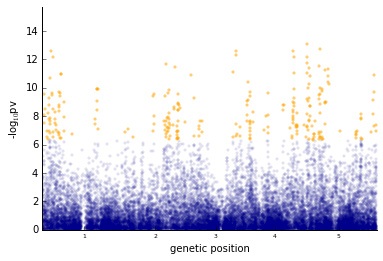

In [7]:
# Genome-wide manhatton plots for one phenotype:
plot_manhattan(position['pos_cum'],pvalues_lm[phenotype_ID].values,chromBounds)




/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


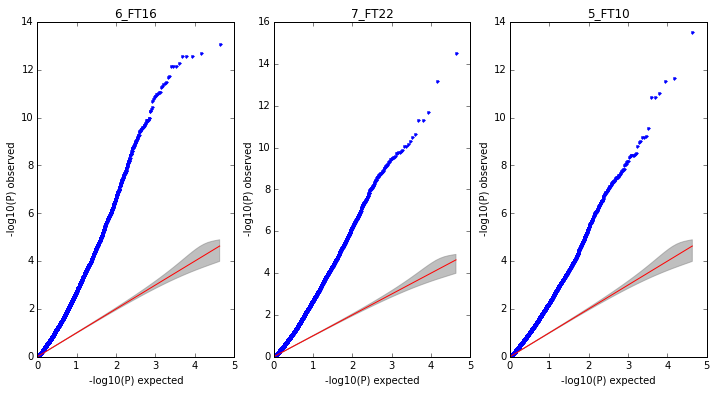

In [8]:
# the formal test QQ-plots
pl.figure(figsize=[12,6])
for ip in xrange(len(phenotype_names)):
    plt = pl.subplot(1,3,ip)
    qqplot(pvalues_lm[phenotype_names[ip]].values)
    pl.title(phenotype_names[ip])

#plt = pl.subplot(1,2,2)
#qqplot(pvalues_lmm[phenotype_ID].values)


# Accounting for population structure based on PCA

In [9]:
#compute principal components from the SNP data
import sklearn.decomposition.pca as pca

#import data: 1000 genomes
#the data used in this study have been pre-converted into an hdf5 file. 
#to preprocess your own data, please use limix command line brinary
genotype_file = './../data/1000g/1000g_chrom20_snps.hdf5'
annotation_file = './../data/1000g/1000g_sample_annotation.hdf5'
geno_reader_1000G  = gr.genotype_reader_tables(genotype_file)
#read annotation
fa = h5py.File(annotation_file,'r')
population_1000G = fa['Population'][:]
#select YRI and CEU populations
#Ipop = (population_1000G=='CEU') | (population_1000G=='YRI')
Ipop = (population_1000G=='CEU') | (population_1000G=='YRI') | (population_1000G=='GBR') | (population_1000G=='FIN')

population_1000G = population_1000G[Ipop]
M1000G = geno_reader_1000G.getGenotypes()[Ipop]
pos1000G = geno_reader_1000G.getPos()['pos']

pc = pca.PCA()
pc_snps = pc.fit_transform(M1000G)

pl.figure(figsize=(15,5))
pl.subplot(1,3,1)
pl.plot(pc_snps[:,0],pc_snps[:,1],'k.')
pl.xlabel('PCA1')
pl.ylabel('PCA2')

#plot the proportion of variance explained by each PC:
pl.subplot(1,3,2)
pl.plot(pc.explained_variance_ratio_,".")
pl.xlabel("number PCs")
pl.ylabel("variance explained")

pl.subplot(1,3,3)
pl.plot(pc.explained_variance_ratio_.cumsum(),".")
pl.xlabel("number PCs")
pl.ylabel("total variance explained")


ImportError: No module named sklearn.decomposition.pca

In [ ]:
#back to arabidopsis:
pc = pca.PCA()
pc_snps = pc.fit_transform(snps)

In [ ]:
#pc_snps = pc.transform(snps)
pl.plot(pc_snps[:,0],pc_snps[:,1],'k.')
pl.xlabel('PCA1')
pl.ylabel('PCA2')

In [ ]:
#plot the proportion of variance explained by each PC:
pl.figure(figsize=(10,5))
pl.subplot(1,2,1)
pl.plot(pc.explained_variance_ratio_,".")
pl.xlabel("number PCs")
pl.ylabel("variance explained")

pl.subplot(1,2,2)
pl.plot(pc.explained_variance_ratio_.cumsum(),".")
pl.xlabel("number PCs")
pl.ylabel("total variance explained")

In [ ]:
covs_with_pcs = sp.concatenate([sp.ones([snps.shape[0],1]),pc_snps],axis=1)

n_components = [0,1,5,10,30]


pl.figure(figsize=[12,20])
#run a mixed model with increasing numbers of PCs
ip = 1
for i in n_components:
    _covs = covs_with_pcs[:,0:i+1]
    lm = qtl.test_lm(snps=snps,pheno=phenotype_std,covs=_covs, test=test)
    pvalues_lm = pd.DataFrame(data=lm.getPv().T,index=data_subsample.geno_ID,
                       columns=phenotypes.columns)
    for phenotype_ID in phenotype_names:
        plt = pl.subplot(len(n_components),len(phenotype_names),ip)
        qqplot(pvalues_lm[phenotype_ID].values) 
        ip+=1
        pl.title('%s: %d PCs' % (phenotype_ID,i))



# Linear mixed models

In [ ]:
#estimate sample relatedness:
pl.imshow(sample_relatedness,aspect='auto')    


In [ ]:
#run a linear mixed model and a standard lmm for comparison
covs = None                 #covariates
searchDelta = False         #specify if delta should be optimized for each SNP
test="lrt"                  #specify type of statistical test

lm = qtl.test_lm(snps=snps,pheno=phenotype_std,
                   covs=covs, test=test)
pvalues_lm = lm.getPv()       # 1xS vector of p-values (S=X.shape[1])#convert P-values to a DataFrame for nice output writing:
pvalues_lm = pd.DataFrame(data=pvalues_lm.T,index=data_subsample.geno_ID,
                       columns=phenotypes.columns)

lmm = qtl.test_lmm(snps=snps,pheno=phenotype_std,
                   K=sample_relatedness,covs=covs, test=test)

pvalues_lmm = lmm.getPv()       # 1xS vector of p-values (S=X.shape[1])#convert P-values to a DataFrame for nice output writing:
pvalues_lmm = pd.DataFrame(data=pvalues_lmm.T,index=data_subsample.geno_ID,
                       columns=phenotypes.columns)

In [ ]:
pl.figure(figsize=[15,5])
plt = pl.subplot(1,2,1)
plot_manhattan(position['pos_cum'],pvalues_lm[phenotype_ID].values,chromBounds)
pl.title('LM')
plt = pl.subplot(1,2,2)
plot_manhattan(position['pos_cum'],pvalues_lmm[phenotype_ID].values,chromBounds)
pl.title('LMM')



In [ ]:
# the formal test QQ-plots
pl.figure(figsize=[12,6])
for ip in xrange(len(phenotype_names)):
    plt = pl.subplot(1,3,ip)
    qqplot(pvalues_lmm[phenotype_names[ip]].values)
    pl.title(phenotype_names[ip])

## Proximal contamination 

In [24]:
#run mixed model on a per chromosome basis:


In [25]:
pv_lmm2 = []
for i_chr in xrange(5):
    I_chrom = (position['chrom']==(i_chr+1)).values
    snps_chrom = snps[:,I_chrom]
    snps_rest  = snps[:,~I_chrom]
    K_rest     = sp.dot(snps_rest,snps_rest.T)
    lmm_window = qtl.test_lmm(snps=snps_chrom,pheno=phenotype_std,
                   K=K_rest,covs=covs, test=test)

    pv_ = lmm_window.getPv()       # 1xS vector of p-values (S=X.shape[1])#convert P-values to a DataFrame for nice output writing:
    pv_lmm2.append(pv_)
pv_lmm2 = sp.concatenate(pv_lmm2,axis=1)
pvalues_lmm2 = pd.DataFrame(data=pv_lmm2.T,index=data_subsample.geno_ID,
                       columns=phenotypes.columns)

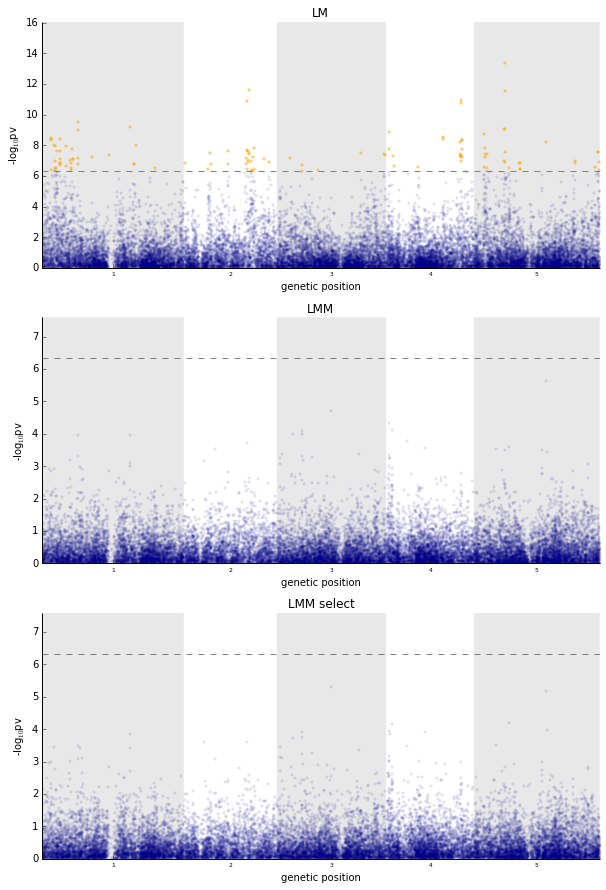

In [26]:
#plot things for one phenotype:

phenotype_ID = '5_FT10'

pl.figure(figsize=[10,15])
plt = pl.subplot(3,1,1)
plot_manhattan(position['pos_cum'],pvalues_lm[phenotype_ID].values,chromBounds)
pl.title('LM')
plt = pl.subplot(3,1,2)
plot_manhattan(position['pos_cum'],pvalues_lmm[phenotype_ID].values,chromBounds)
pl.title('LMM')
plt = pl.subplot(3,1,3)
plot_manhattan(position['pos_cum'],pvalues_lmm2[phenotype_ID].values,chromBounds)
pl.title('LMM select')


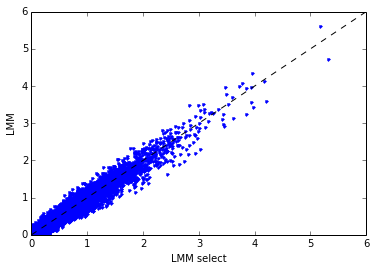

In [27]:
pl.plot(-sp.log10(pvalues_lmm2[phenotype_ID]),-sp.log10(pvalues_lmm[phenotype_ID]),'.')
ymax = max(pl.xlim()[1],pl.ylim()[1])
pl.plot([0,ymax],[0,ymax],'k--')
pl.xlabel('LMM select')
pl.ylabel('LMM')